<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# 9.02 Lab: Forecasting 

_Authors: Jeff Hale_

---

Let's practice time series forecasting.

---

### Data 

The Rossmann dataset.

---

Goal: forecast total daily sales for the Rossmann stores for 2015. This is a univariate time series problem. 

#### Get the data ready for modeling



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.utils.plotting.forecasting import plot_ys

import pmdarima as pmd

In [2]:
import sktime
sktime.__version__

'0.4.2'

In [3]:
df_raw = pd.read_csv('data/rossmann.csv')

/home/vivi/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df = df_raw.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
[type(i) for i in df['StateHoliday'].unique()]

[str, str, str, str, int]

In [8]:
df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [9]:
df['StateHoliday'] = df['StateHoliday'].map({
    '0':0,
    'a':1,
    'b':2,
    'c':3,
    0:0
})

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  int64         
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 69.8 MB


In [11]:
df = df.set_index('Date')

In [12]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


#### Split the data into training and test sets. Make the 2015 data the test set.

In [13]:
train = df[df.index < '2015-01-01']
test = df[df.index > '2015-01-01']

In [14]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2014-12-31,1,3,2605,327,1,0,0,1
2014-12-31,2,3,2269,252,1,0,0,1
2014-12-31,3,3,3804,408,1,0,0,1
2014-12-31,4,3,10152,1311,1,0,0,1
2014-12-31,5,3,1830,217,1,0,0,1


In [15]:
test.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


# Plot it 

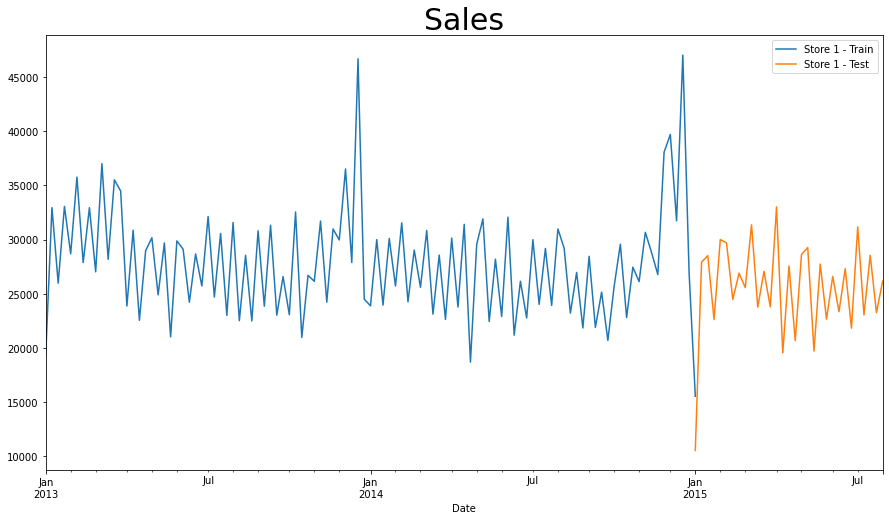

In [16]:
train[train['Store'] == 1].resample('W').sum()['Sales'].plot(figsize=(15,8), label='Store 1 - Train')
test[test['Store'] == 1].resample('W').sum()['Sales'].plot(figsize=(15,8), label='Store 1 - Test')
plt.title('Sales', fontsize=30)
plt.legend();

Text(0.5, 1.0, 'Sales')

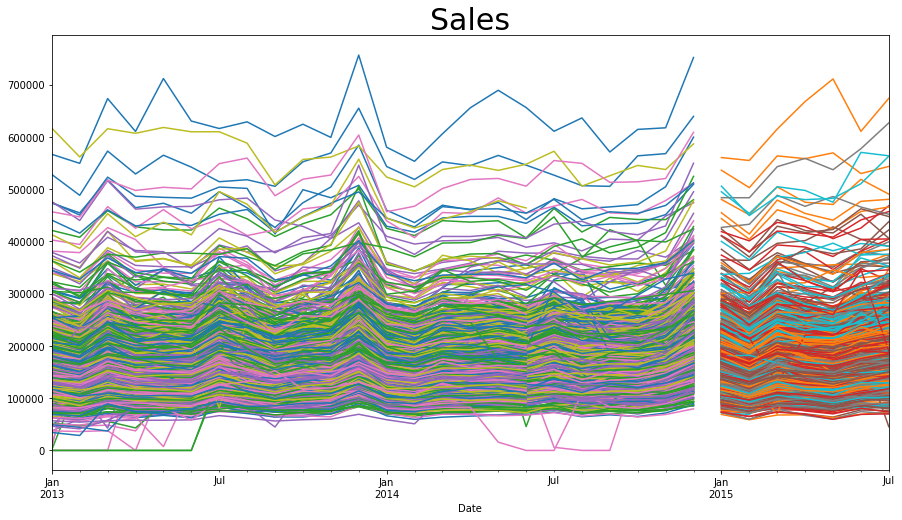

In [17]:
for i in train['Store'].unique():
    train[train['Store'] == i].resample('M').sum()['Sales'].plot(figsize=(15,8), label=f'Store {i} - Train')
    test[test['Store'] == i].resample('M').sum()['Sales'].plot(figsize=(15,8), label=f'Store {i} - Test')
plt.title('Sales', fontsize=30)

In [18]:
# For our own sake, we're only considering one store, or we can consider the company as a whole

## Baseline (naive) models

#### Make baseline models that are the mean, last value, and seasonal. Plot the predictions on the test set.

I strongly suggest you use sktime to make the forecasts and plot the predicitons.


#### Score your models on the test set using MAE.

In [19]:
y_train = train[train['Store'] == 1]['Sales']
y_test = test[test['Store'] == 1]['Sales']

In [20]:
y_train = y_train.reset_index()['Sales']

In [21]:
y_test = y_test.reset_index()['Sales']

In [22]:
y_test.index = y_test.index + len(y_train)

In [23]:
y_test.index

RangeIndex(start=730, stop=941, step=1)

In [24]:
naive_last_model = NaiveForecaster(strategy='last')
naive_last_model.fit(y_train)

NaiveForecaster()

In [25]:
df_predictions = pd.DataFrame(naive_last_model.predict(list(range(1, len(y_test)+1))), columns=['last'])

In [26]:
naive_mean_model = NaiveForecaster(strategy='mean')
naive_mean_model.fit(y_train)

NaiveForecaster(strategy='mean')

In [27]:
df_predictions['mean'] = naive_mean_model.predict(list(range(1, len(y_test)+1)))

In [28]:
naive_seasonal = NaiveForecaster(strategy='last', sp=365)
naive_seasonal.fit(y_train)

NaiveForecaster(sp=365)

In [29]:
df_predictions['seasonal'] = naive_seasonal.predict(list(range(1, len(y_test)+1)))

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

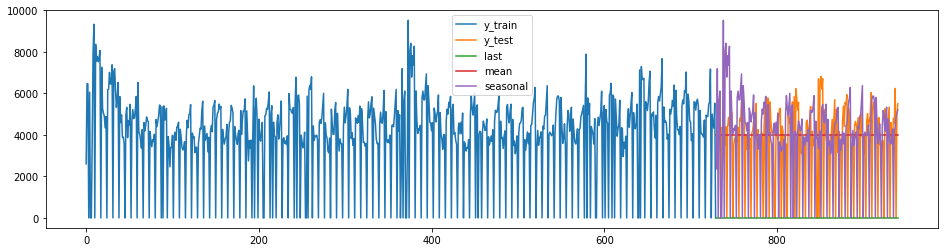

In [30]:
plot_ys(y_train, y_test, df_predictions['last'], df_predictions['mean'], df_predictions['seasonal'], labels=['y_train', 'y_test', 'last', 'mean', 'seasonal'])

In [31]:
[mean_absolute_error(y_test, i) for i in [y_test, df_predictions['last'], df_predictions['mean'], df_predictions['seasonal']]]

[0.0, 3755.004739336493, 1303.4616373433744, 2067.3649289099526]

In [32]:
# I still don't like how I can barely understand what the plot says

In [33]:
y_train2 = train[train['Store'] == 1]['Sales'].resample('W').sum().reset_index()['Sales']
y_test2 = test[test['Store'] == 1]['Sales'].resample('W').sum().reset_index()['Sales']
y_test2.index = y_test2.index + len(y_train2)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

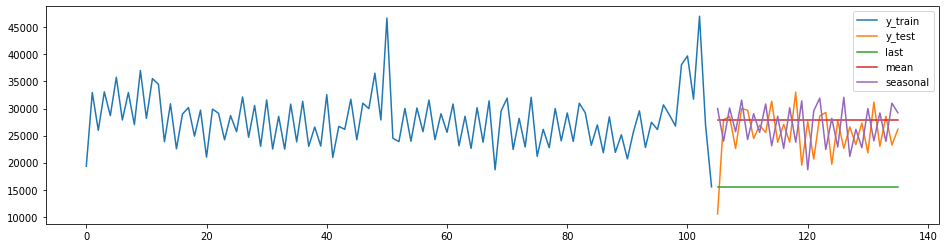

In [34]:
naive_last_model = NaiveForecaster(strategy='last')
naive_last_model.fit(y_train2)
df_predictions2 = pd.DataFrame(naive_last_model.predict(list(range(1, len(y_test2)+1))), columns=['last'])
naive_mean_model = NaiveForecaster(strategy='mean')
naive_mean_model.fit(y_train2)
df_predictions2['mean'] = naive_mean_model.predict(list(range(1, len(y_test2)+1)))
naive_seasonal = NaiveForecaster(strategy='last', sp=52)
naive_seasonal.fit(y_train2)
df_predictions2['seasonal'] = naive_seasonal.predict(list(range(1, len(y_test2)+1)))
plot_ys(y_train2, y_test2, df_predictions2['last'], df_predictions2['mean'], df_predictions2['seasonal'], labels=['y_train', 'y_test', 'last', 'mean', 'seasonal'])

In [35]:
[mean_absolute_error(y_test2, i) for i in [y_test2, df_predictions2['last'], df_predictions2['mean'], df_predictions2['seasonal']]]

[0.0, 10346.967741935483, 3560.6199692780338, 6176.645161290323]

## Holt-Winters

#### Make a model using Holt-Winters (triple exponential smoothing). Use statsmodels, pmdarima, or sktime. 

α<sup>2</sup>

\\[a^2\\]

In [36]:
y_train

0      2605
1      6466
2      6463
3         0
4      6057
       ... 
725    4997
726    4486
727    4327
728    5530
729       0
Name: Sales, Length: 730, dtype: int64

In [37]:
es = ExponentialSmoothing()

In [38]:
es.fit(y_train)

/home/vivi/miniconda3/lib/python3.8/site-packages/sktime/forecasting/exp_smoothing.py:94: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  self._forecaster = _ExponentialSmoothing(
/home/vivi/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/home/vivi/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:1112: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  warnings.warn(
/home/vivi/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:1132: FutureWarning: use_basinhopping is deprecated. Set optimization method using 'method'. This option will be removed after 0.13 is released.
  warnings.warn(
/home/vivi/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: Convergence

ExponentialSmoothing()

In [39]:
df_hw_preds = pd.DataFrame(es.predict(list(range(1, len(y_test)+1))), columns=['D'])

In [40]:
es = ExponentialSmoothing()
es.fit(y_train2)

/home/vivi/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


ExponentialSmoothing()

In [41]:
preds = es.predict(list(range(1, len(y_test2)+1)))

#### Plot the test set predictions vs. actuals.

In [42]:
df_hw_preds['M'] = preds

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

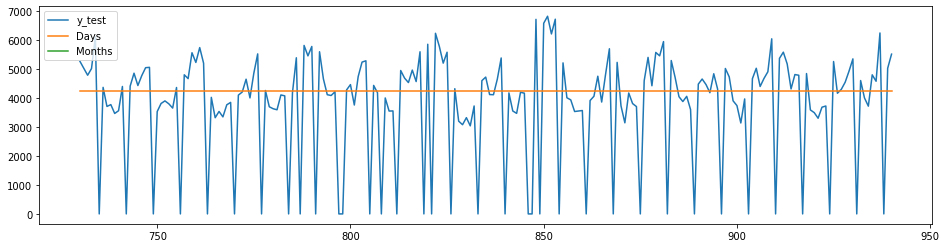

In [43]:
plot_ys(y_test, df_hw_preds['D'], df_hw_preds['M'], labels=['y_test', 'Days', 'Months'])

#### Score your models on the test set using MAE. 

In [44]:
mean_absolute_error(y_test, df_hw_preds['D'])

1289.8976916428937

## SARIMA
#### Make a model using SARIMA. Use statsmodels, pmdarima, or sktime. 

In [ ]:
model = pmd.auto_arima(y_train, m=365, trace=True, suppress_warnings=True, n_jobs=-1)

/home/vivi/miniconda3/lib/python3.8/site-packages/pmdarima/arima/_validation.py:74: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic


#### Plot the test set predictions vs. actuals.

In [ ]:
predictions = model.predict(y_test.shape[0])

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(predictions, label='SARIMA_auto')
plt.legend(loc='best');

#### Score your models on the test set using MAE. 

In [ ]:
mean_absolute_error(y_test, predictions)

#### Which model performs best?